In [316]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

plt.style.use('ggplot')

%matplotlib inline

In [371]:
# import numpy as np
# import pandas as pd
import urllib.request
import urllib.parse
from functools import reduce
from datetime import datetime

class GitHubParser:
    
    def __init__(self, user, token):
        self.user = user
        self.token = token       
    
    def loadProjects(self, projects, timePeriod):    
        prjDFs = []
        for prj in projects:
            print('Loading project {}...'.format(prj))
            df = self._getContributors(self.user, self.token, prj)
            prjDFs.append(self._pivotByTimePeriod(df, timePeriod))
            df.instrument_name = prj
            print('')
            
        return prjDFs
    
    def joinByTime(self, projectDFs, timePeriod):
        print('Composing general dataframe')
        return pd.concat(projectDFs).groupby([timePeriod]).sum()

    def _toDF(self, resp):
        print('    parsing response...')
        df = pd.read_json(resp, orient='records')
        print('        created pandas dataframe')
        # leave only name from author
        df['author'] = df.apply(lambda r: r['author']['login'], axis=1)
        print('        found {} authors'.format(len(df.index)))
        df = df.drop(columns=['total'])
        return df

    def _getContributors(self, user, token, project):
        ghApi='https://api.github.com'

        url='{}/repos/{}/{}/stats/contributors'.format(ghApi, user, project);
        print('    GET {}'.format(url))

        req = urllib.request.Request(url, 
                                     headers={'Authorization': 'token {}'
                                              .format(token)})

        resp = {}
        with urllib.request.urlopen(req) as r:
            resp = r.read()
            return self._toDF(resp) 
        
    def _tstotime(self, ts, f):
        return datetime.fromtimestamp(ts).strftime(f)
       
    def _authorCommitsDF(self, author, weeks, timePeriod):
        wdf = pd.DataFrame(weeks)
        if timePeriod == 'week':
            wdf[timePeriod] = wdf.apply(lambda r: self._tstotime(r['w'], '%Y-%m-%d'), axis=1)
            
        if timePeriod == 'month':    
            wdf[timePeriod] = wdf.apply(lambda r: self._tstotime(r['w'], '%Y-%m'), axis=1)
            
        if timePeriod == 'year':    
            wdf[timePeriod] = wdf.apply(lambda r: self._tstotime(r['w'], '%Y'), axis=1)
            
        wdf = wdf.drop(columns=['a', 'd', 'w'])
        wdf = wdf.rename(columns={"c": author})
        
        if timePeriod != 'week':
            wdf = wdf.groupby(timePeriod, as_index=False).sum()
            
        #change columns order
        cols = wdf.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        wdf = wdf[cols]
        return wdf

    def _pivotByTimePeriod(self, df, timePeriod):
        print('    extracting {}s...'.format(timePeriod))
        weekDFs = []
        for i, r in df.iterrows():
            weekDFs.append(self._authorCommitsDF(r['author'], r['weeks'], timePeriod))

        final_df = reduce(lambda left,right: 
                          left.join(right.set_index(timePeriod), on=timePeriod), 
                          weekDFs)
        
        print('        found {}'.format(len(final_df.index)))
        final_df = final_df.set_index(timePeriod)
        return final_df     
    

In [318]:
def plotBars(df):
    df.plot(kind='bar', stacked=True, 
                    colormap=ListedColormap(sns.color_palette("GnBu", 10)),
                    figsize=(24,6))

Loading project gamma-wreg-v3...
    GET https://api.github.com/repos/ancalled/gamma-wreg-v3/stats/contributors
    parsing response...
        created pandas dataframe
        found 5 authors
    extracting months...
        found 26

Loading project certex-cms-frontend...
    GET https://api.github.com/repos/ancalled/certex-cms-frontend/stats/contributors
    parsing response...
        created pandas dataframe
        found 7 authors
    extracting months...
        found 23

Composing general dataframe


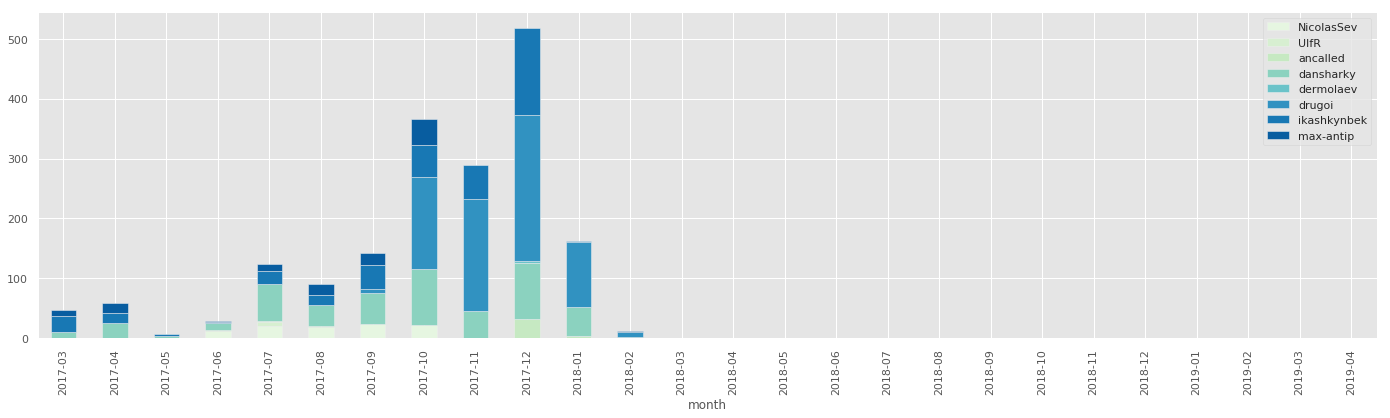

In [381]:
token=''
user=''
projects=[]
# timePeriod = 'week'
timePeriod = 'month'

gp = GitHubParser(user, token)

projectDFs = gp.loadProjects(projects, timePeriod)

plotBars(gp.joinByTime(projectDFs, timePeriod))
